In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

C:\Users\afree\AppData\Local\Temp\ipykernel_4704\1400341112.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

In [3]:
def visualize_preds(table,y_true, y_pred, title):
    ls = []
    f = plt.figure(figsize = (8,8))
    cf = confusion_matrix(y_true, y_pred)
    sb.heatmap(cf, fmt='.0f', annot=True)
    
    accuracy  = np.trace(cf) / float(np.sum(cf))

    # Metrics for Binary Confusion Matrices
    if sum(cf[:,1]) == 0:
        precision = 0.0;
    else:
        precision = cf[1,1] / sum(cf[:,1])
        
    if sum(cf[1,:]) == 0:
        recall = 0.0;
    else:
        recall    = cf[1,1] / sum(cf[1,:])
        
    if (precision + recall) == 0:
        f1_score = 0.0;
    else:
        f1_score  = 2 *precision * recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
        accuracy,precision,recall,f1_score)
    
    ls.append(accuracy)
    ls.append(precision)
    ls.append(recall)
    ls.append(f1_score)
    ls = pd.DataFrame(ls)
    table = pd.concat([table,ls], axis = 1)
    
    plt.xlabel('Predicted' + stats_text)
    plt.ylabel('Actual')
    plt.title(title)
    
    return table

In [4]:
table1 = pd.DataFrame()
table2 = pd.DataFrame()

#### Importing the Oversampled Dataset

In [11]:
nasaOversample_train = pd.read_csv("Datasets/oversampled_train.csv", index_col = 0)
nasaOversample_train = nasaOversample_train.drop(['NEO_REFERENCE_ID', 'EST_DIA_IN_M(MIN)', 'MISS_DIST.(KILOMETERS)', 'PERIHELION_DISTANCE', 'APHELION_DIST', 'PERIHELION_TIME', 'MEAN_ANOMALY', 'MEAN_MOTION'], axis = 1)
nasaOversample_train

,EST_DIA_IN_M(MAX),RELATIVE_VELOCITY_KM_PER_SEC,HAZARDOUS,RISK_CATEGORY
0,411.187571,9.551351,0,1
1,113.250461,3.838017,0,0
2,567.596853,6.477856,0,1
3,748.238376,18.027267,1,2
4,156.329154,24.300910,0,1
...,...,...,...,...
3211,1132.504611,17.495185,0,2
3212,1081.533507,12.736781,0,2
3213,986.370281,19.408931,0,2
3214,542.050786,4.099881,1,2


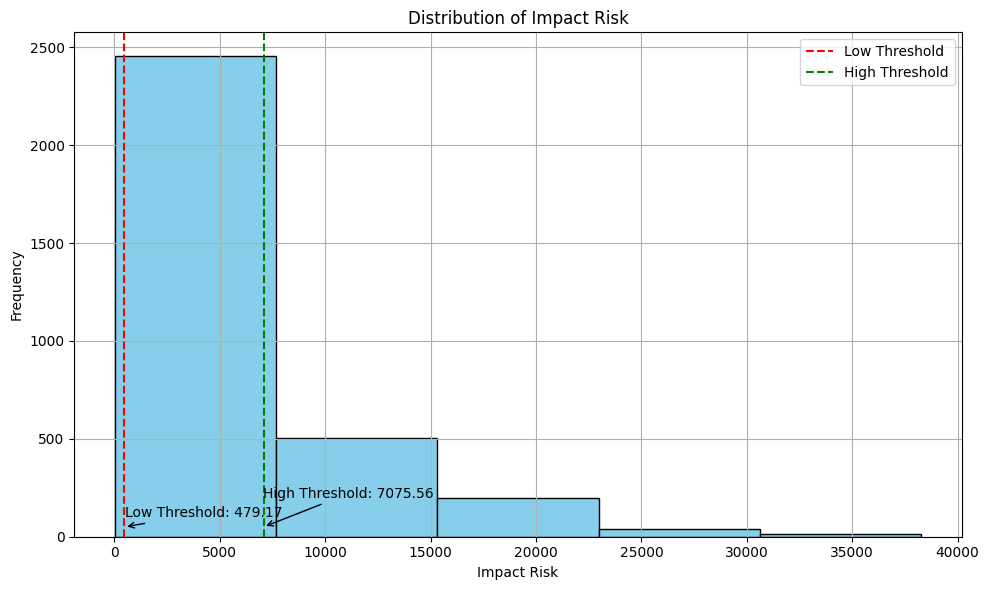

Low Threshold: 479.17470486772226
High Threshold: 7075.558111088614


In [12]:
nasaOversample_train['IMPACT_RISK'] = nasaOversample_train['EST_DIA_IN_M(MAX)'] * nasaOversample_train['RELATIVE_VELOCITY_KM_PER_SEC']

# Check the distribution of IMPACT RISK
risk_values = nasaOversample_train['IMPACT_RISK']
risk_values.describe()

# Determine thresholds based on the distribution
low_threshold = risk_values.quantile(0.25)
high_threshold = risk_values.quantile(0.75)

# Plotting the histogram with annotations for thresholds
plt.figure(figsize=(10, 6))
plt.hist(risk_values, bins=5, color='skyblue', edgecolor='black')
plt.axvline(low_threshold, color='r', linestyle='--', label='Low Threshold')
plt.axvline(high_threshold, color='g', linestyle='--', label='High Threshold')
plt.xlabel('Impact Risk')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Risk')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate the thresholds on the histogram
plt.annotate(f'Low Threshold: {low_threshold:.2f}', xy=(low_threshold, 50), xytext=(low_threshold + 5, 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate(f'High Threshold: {high_threshold:.2f}', xy=(high_threshold, 50), xytext=(high_threshold - 10, 200),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

print('Low Threshold:', low_threshold)
print('High Threshold:', high_threshold)

# Create a new column 'Impact Risk Category' based on calculated thresholds
nasaOversample_train['IMPACT_RISK_CATEGORY'] = pd.cut(nasaOversample_train['IMPACT_RISK'], bins=[-np.inf, low_threshold, high_threshold, np.inf],labels=['Low', 'Medium', 'High'])

In [24]:
# Encoding the target variable (IMPACT RISK CATEGORY)
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler

le = LabelEncoder()
nasaOversample_train['IMPACT_RISK_ENCODED'] = le.fit_transform(nasaOversample_train['IMPACT_RISK_CATEGORY'])

# Convert Hazardous to encoded
nasaOversample_train['HAZARDOUS_ENCODED'] = nasaOversample_train['HAZARDOUS'].astype(int)

# Features and target preparation
X_oversampled = nasaOversample_train[['IMPACT_RISK','HAZARDOUS_ENCODED']]
y_oversampled = nasaOversample_train['IMPACT_RISK_ENCODED']

# Feature scaling
scaler = StandardScaler()
X_oversampled_scaled = scaler.fit_transform(X_oversampled)

C:\Users\afree\AppData\Local\Temp\ipykernel_4704\1017467698.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='IMPACT_RISK_CATEGORY', data=nasaOversample_train, palette='viridis')


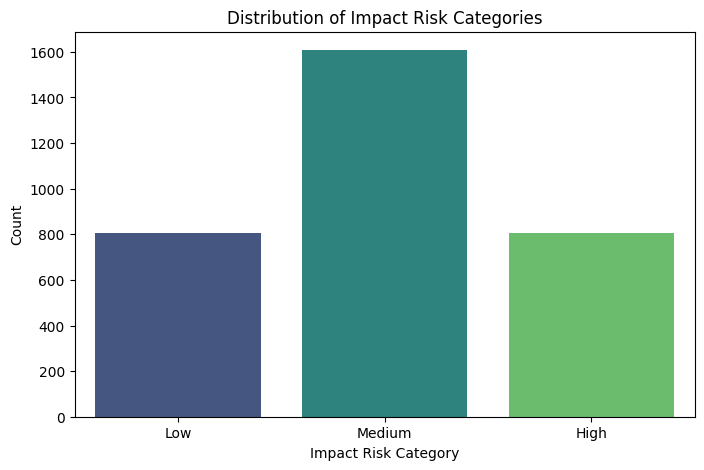

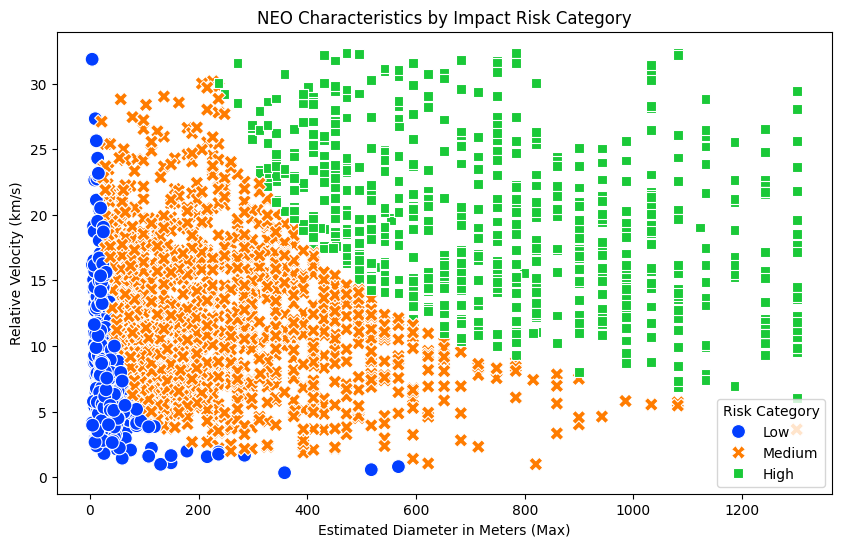

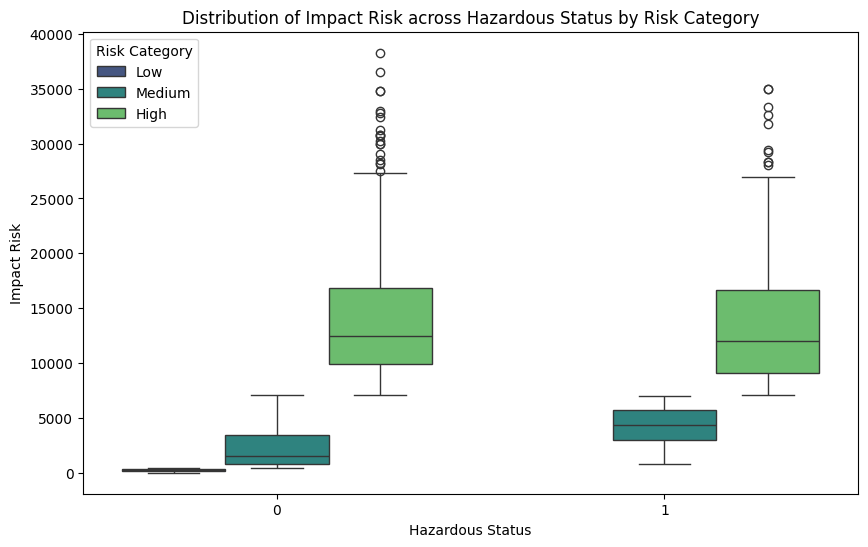

In [25]:
# Histogram of Impact Risk Categories
plt.figure(figsize=(8, 5))
sb.countplot(x='IMPACT_RISK_CATEGORY', data=nasaOversample_train, palette='viridis')
plt.title('Distribution of Impact Risk Categories')
plt.xlabel('Impact Risk Category')
plt.ylabel('Count')
plt.show()

# Scatter Plot with Categories
plt.figure(figsize=(10, 6))
sb.scatterplot(data=nasaOversample_train, x='EST_DIA_IN_M(MAX)', y='RELATIVE_VELOCITY_KM_PER_SEC', hue='IMPACT_RISK_CATEGORY', style='IMPACT_RISK_CATEGORY', palette='bright', s=100)
plt.title('NEO Characteristics by Impact Risk Category')
plt.xlabel('Estimated Diameter in Meters (Max)')
plt.ylabel('Relative Velocity (km/s)')
plt.legend(title='Risk Category')
plt.show()

# Violin Plot with Categories
plt.figure(figsize=(10, 6))
sb.boxplot(x='HAZARDOUS_ENCODED', y='IMPACT_RISK', hue='IMPACT_RISK_CATEGORY', data=nasaOversample_train, palette='viridis')
plt.title('Distribution of Impact Risk across Hazardous Status by Risk Category')
plt.xlabel('Hazardous Status')
plt.ylabel('Impact Risk')
plt.legend(title='Risk Category')
plt.show()

#### Importing the Smotetomek Dataset

In [16]:
#IMPORTING CLEANED TRAIN DATA USING SMOTETOMEK SAMPLING
nasaSmotetomek_train = pd.read_csv("Datasets/smotetomek_train.csv", index_col = 0)
nasaSmotetomek_train = nasaSmotetomek_train.drop(['NEO_REFERENCE_ID', 'EST_DIA_IN_M(MIN)', 'MISS_DIST.(KILOMETERS)', 'PERIHELION_DISTANCE', 'APHELION_DIST', 'PERIHELION_TIME', 'MEAN_ANOMALY', 'MEAN_MOTION'], axis = 1)
nasaSmotetomek_train

,EST_DIA_IN_M(MAX),RELATIVE_VELOCITY_KM_PER_SEC,HAZARDOUS,RISK_CATEGORY
0,113.250461,3.838017,0,0
1,567.596853,6.477856,0,1
2,748.238376,18.027267,1,2
3,156.329154,24.300910,0,1
4,594.346868,10.896092,0,1
...,...,...,...,...
2411,322.420730,16.066831,1,2
2412,407.979344,28.224700,0,2
2413,880.558727,13.826735,1,2
2414,443.214353,23.729151,0,2


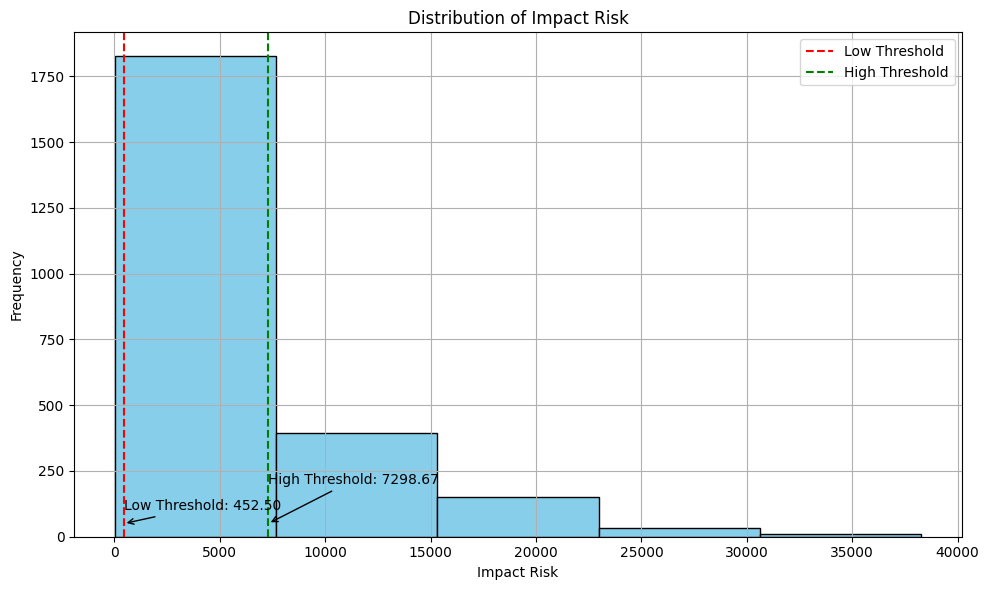

Low Threshold: 452.49731830343205
High Threshold: 7298.666318419686


In [18]:
nasaSmotetomek_train['IMPACT_RISK'] = nasaSmotetomek_train['EST_DIA_IN_M(MAX)'] * nasaSmotetomek_train['RELATIVE_VELOCITY_KM_PER_SEC']

# Check the distribution of IMPACT RISK
risk_values = nasaSmotetomek_train['IMPACT_RISK']
risk_values.describe()

# Determine thresholds based on the distribution
low_threshold = risk_values.quantile(0.25)
high_threshold = risk_values.quantile(0.75)

# Plotting the histogram with annotations for thresholds
plt.figure(figsize=(10, 6))
plt.hist(risk_values, bins=5, color='skyblue', edgecolor='black')
plt.axvline(low_threshold, color='r', linestyle='--', label='Low Threshold')
plt.axvline(high_threshold, color='g', linestyle='--', label='High Threshold')
plt.xlabel('Impact Risk')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Risk')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate the thresholds on the histogram
plt.annotate(f'Low Threshold: {low_threshold:.2f}', xy=(low_threshold, 50), xytext=(low_threshold + 5, 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate(f'High Threshold: {high_threshold:.2f}', xy=(high_threshold, 50), xytext=(high_threshold - 10, 200),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

print('Low Threshold:', low_threshold)
print('High Threshold:', high_threshold)

# Create a new column 'Impact Risk Category' based on calculated thresholds
nasaSmotetomek_train['IMPACT_RISK_CATEGORY'] = pd.cut(nasaSmotetomek_train['IMPACT_RISK'], bins=[-np.inf, low_threshold, high_threshold, np.inf],labels=['Low', 'Medium', 'High'])

In [26]:
# Encoding the target variable (IMPACT RISK CATEGORY)
nasaSmotetomek_train['IMPACT_RISK_ENCODED'] = le.fit_transform(nasaSmotetomek_train['IMPACT_RISK_CATEGORY'])

# Convert Hazardous to encoded
nasaSmotetomek_train['HAZARDOUS_ENCODED'] = nasaSmotetomek_train['HAZARDOUS'].astype(int)

# Features and target preparation
X_smotetomek = nasaSmotetomek_train[['IMPACT_RISK','HAZARDOUS_ENCODED']]
y_smotetomek = nasaSmotetomek_train['IMPACT_RISK_ENCODED']

# Feature scaling
X_smotetomek_scaled = scaler.fit_transform(X_smotetomek)

C:\Users\afree\AppData\Local\Temp\ipykernel_4704\1583272998.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='IMPACT_RISK_CATEGORY', data=nasaSmotetomek_train, palette='viridis')


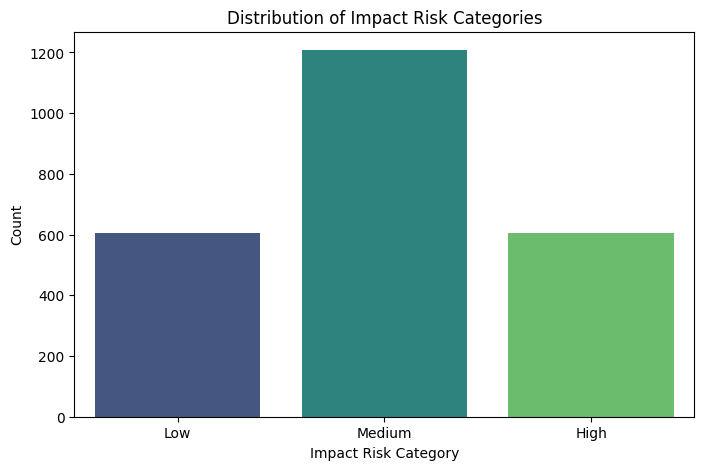

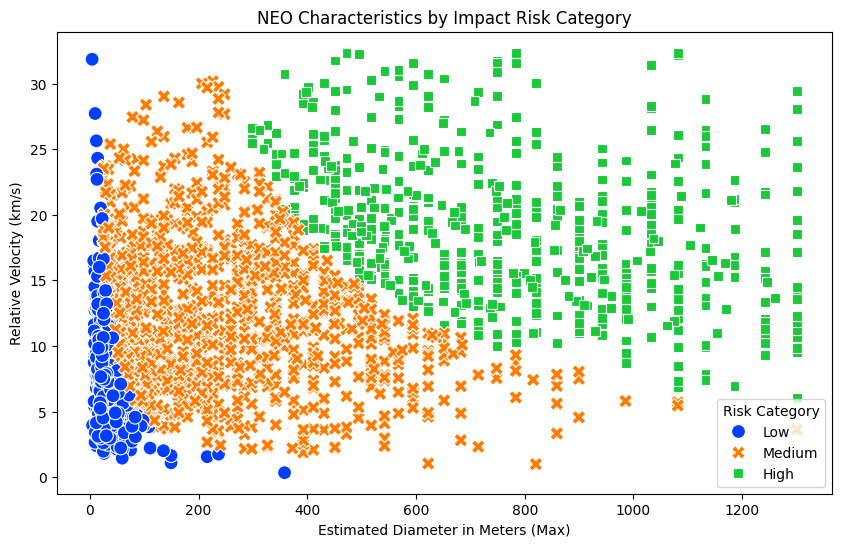

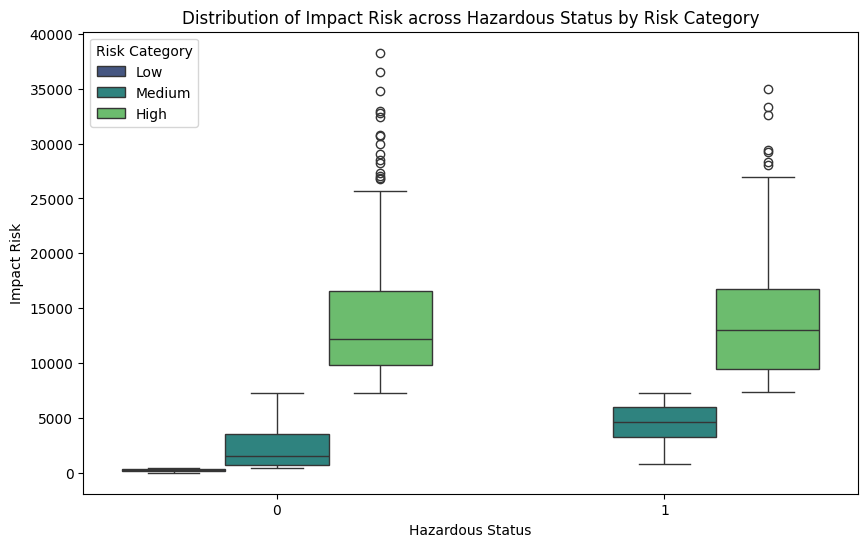

In [27]:
# Histogram of Impact Risk Categories
plt.figure(figsize=(8, 5))
sb.countplot(x='IMPACT_RISK_CATEGORY', data=nasaSmotetomek_train, palette='viridis')
plt.title('Distribution of Impact Risk Categories')
plt.xlabel('Impact Risk Category')
plt.ylabel('Count')
plt.show()

# Scatter Plot with Categories
plt.figure(figsize=(10, 6))
sb.scatterplot(data=nasaSmotetomek_train, x='EST_DIA_IN_M(MAX)', y='RELATIVE_VELOCITY_KM_PER_SEC', hue='IMPACT_RISK_CATEGORY', style='IMPACT_RISK_CATEGORY', palette='bright', s=100)
plt.title('NEO Characteristics by Impact Risk Category')
plt.xlabel('Estimated Diameter in Meters (Max)')
plt.ylabel('Relative Velocity (km/s)')
plt.legend(title='Risk Category')
plt.show()

# Violin Plot with Categories
plt.figure(figsize=(10, 6))
sb.boxplot(x='HAZARDOUS_ENCODED', y='IMPACT_RISK', hue='IMPACT_RISK_CATEGORY', data=nasaSmotetomek_train, palette='viridis')
plt.title('Distribution of Impact Risk across Hazardous Status by Risk Category')
plt.xlabel('Hazardous Status')
plt.ylabel('Impact Risk')
plt.legend(title='Risk Category')
plt.show()

#### Logistic Regression

In [30]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Train with oversampled data
model.fit(X_oversampled_scaled, y_oversampled)
predictions_oversampled = model.predict(X_oversampled_scaled)

# Train with bootstrapped data
model.fit(X_smotetomek_scaled, y_smotetomek)
predictions_smotetomek = model.predict(X_smotetomek_scaled)

In [31]:
def plot_confusion_matrix(y_true, y_pred, title):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Use Seaborn to create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [34]:
def evaluate_predictions(y_true, y_pred, dataset_type):
    print(f"Results for {dataset_type} Dataset:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-Score:", f1_score(y_true, y_pred, average='weighted'))
    print()

# Evaluate both models
evaluate_predictions(y_oversampled, predictions_oversampled, 'Oversampled')
evaluate_predictions(y_smotetomek, predictions_smotetomek, 'Smotetomek')

Results for Oversampled Dataset:
Accuracy: 0.9493159203980099
Precision: 0.955619382537962
Recall: 0.9493159203980099
F1-Score: 0.9500958817844682

Results for Smotetomek Dataset:
Accuracy: 0.9461920529801324
Precision: 0.9543326735864545
Recall: 0.9461920529801324
F1-Score: 0.9471646862595237



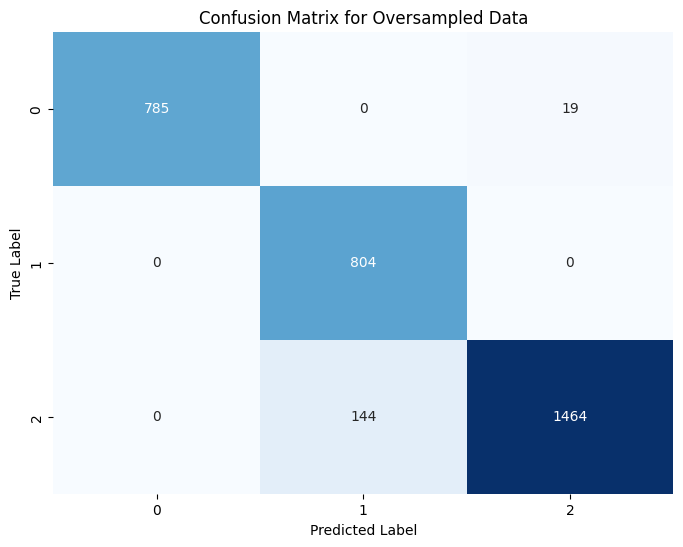

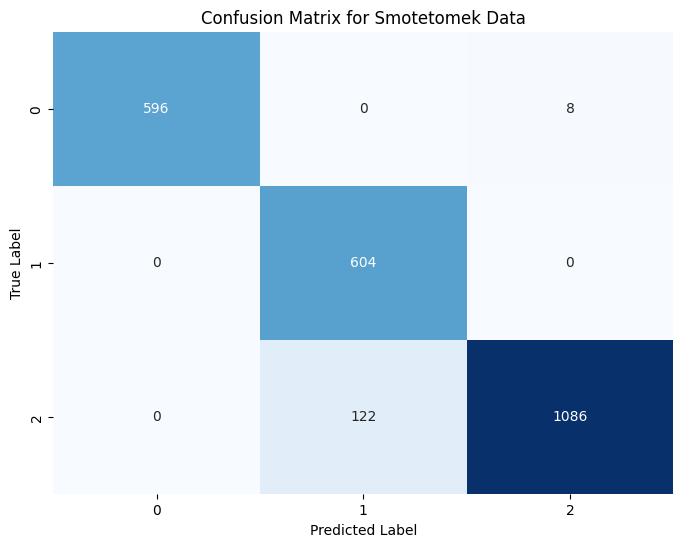

In [35]:
plot_confusion_matrix(y_oversampled, predictions_oversampled, 'Confusion Matrix for Oversampled Data')
plot_confusion_matrix(y_smotetomek, predictions_smotetomek, 'Confusion Matrix for Smotetomek Data')

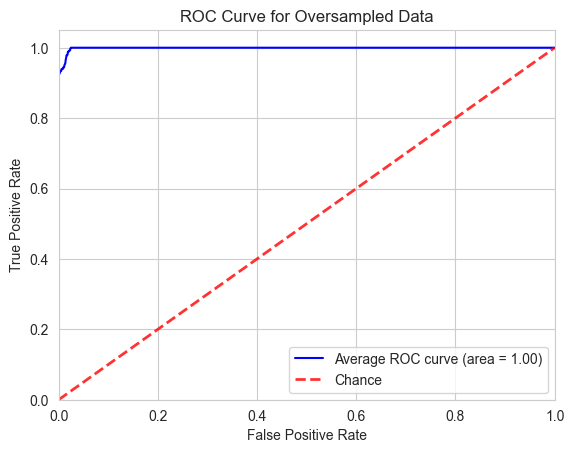

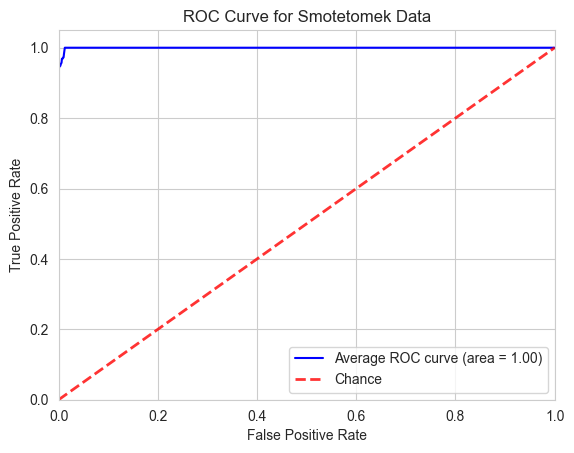

In [36]:
def plot_roc_curve(y_true_bin, X_set_scaled, title):
    # Set the Seaborn style
    sb.set_style("whitegrid")

    # Binarize the output classes for ROC plotting
    n_classes = y_true_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], model.predict_proba(X_set_scaled)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    plt.figure()
    plt.plot(all_fpr, mean_tpr, color='blue',
             label='Average ROC curve (area = {0:0.2f})'.format(np.mean(list(roc_auc.values()))))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Prepare data for ROC
y_oversampled_bin = label_binarize(y_oversampled, classes=[0, 1, 2])
y_smotetomek_bin = label_binarize(y_smotetomek, classes=[0, 1, 2])

# Plot ROC curves
plot_roc_curve(y_oversampled_bin, X_oversampled_scaled, 'ROC Curve for Oversampled Data')
plot_roc_curve(y_smotetomek_bin, X_smotetomek_scaled, 'ROC Curve for Smotetomek Data')